In [1]:
import os
from itertools import cycle
from glob import glob
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import load_img

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Rectangle, Polygon, Circle, PathPatch
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import PatchCollection, PolyCollection, LineCollection
import matplotlib.colors as mcolors
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras import Model
from tensorflow.types.experimental import TensorLike

from src.classes import CategoricalDataGen
from src.data_worker import LabelWorker, init_COCO
from src.utils import *
from src.models.layers import *
from src.models.models import YOLO_Loss
from src.disviz import setup_labels_plot

2023-02-05 16:47:28.934376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 16:47:28.997777: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
%aimport src.utils
%aimport src.classes
%aimport src.data_worker
%aimport src.models.layers
%aimport src.models.models

In [4]:
color = cycle(["orange", "crimson", "tomato",
               "springgreen", "aquamarine", 
               "fuchsia", "deepskyblue", 
               "mediumorchid", "gold"])
images = sorted(glob("./data/images/train/*"))

In [5]:
data = init_COCO("./data/", ['train', 'val', 'test'])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [6]:
labeler = LabelWorker(data_name='train',
                      coco_obj=data,
                      image_path='./data/images/',
                      input_size=(1440, 1920),
                      target_size=(576, 768))

In [8]:
num_anchors = 9
labels = labeler.annot_to_tensor()[:16]
anchors = stack_anchors(generate_anchors(labels, boxes_per_cell=num_anchors, random_state=42))
label_corners = get_corners(labels, img_width=768, img_height=576)
anchor_corners = get_corners(anchors)
label_edges = get_edges(label_corners)
anchor_edges = get_edges(anchor_corners)
print(f"labels shape: {labels.shape}")
print(f"label_corners shape: {label_corners.shape}")
print(f"label_edges shape: {label_edges.shape}")
print(f"anchors shape: {anchors.shape}")
print(f"anchor_corners shape: {anchor_corners.shape}")
print(f"anchor_edges shape: {anchor_edges.shape}")

2023-02-05 16:47:50.405512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 16:47:50.408028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 16:47:50.408055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 16:47:50.410085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 16:47:50.410110: I tensorflow/com

knudge_coords: (12, 9, 2)
anchor_box_template: (16, 12, 9, 9, 5)
anchor_box_template: (16, 12, 9, 9, 5)
anchor_box_template: (16, 12, 9, 9, 5)
units spec1: 5
anchors spec1: (16, 108, 9, 5)
phi: (16, 18, 1)
phi: (16, 108, 9, 1)
labels shape: (16, 18, 19)
label_corners shape: (16, 18, 4, 2)
label_edges shape: (16, 18, 4, 2, 2)
anchors shape: (16, 108, 9, 5)
anchor_corners shape: (16, 108, 9, 4, 2)
anchor_edges shape: (16, 108, 9, 4, 2, 2)


In [9]:
arr = labels[..., -1:].flat
max_idx = tf.argsort(arr, direction="DESCENDING")
max_idx = np.unravel_index(max_idx, (16, 18, 1))

labels[..., -1:][max_idx]

array([9.91847634e-01, 9.84041929e-01, 9.81709003e-01, 9.56842482e-01,
       9.53565955e-01, 9.51803148e-01, 9.44878638e-01, 9.28670645e-01,
       9.26697254e-01, 9.18160200e-01, 9.17902231e-01, 9.17750537e-01,
       9.11518812e-01, 9.03424025e-01, 8.98126721e-01, 8.90162766e-01,
       8.81721020e-01, 8.73184919e-01, 8.67969275e-01, 8.67708266e-01,
       8.63421082e-01, 8.63371432e-01, 8.60602438e-01, 8.60602438e-01,
       8.59678090e-01, 8.54716241e-01, 8.49941432e-01, 8.36490154e-01,
       8.29888880e-01, 8.27348471e-01, 8.26312661e-01, 8.23541462e-01,
       8.23511362e-01, 8.18362713e-01, 8.16874623e-01, 8.16273630e-01,
       8.13945353e-01, 8.07692826e-01, 8.00076604e-01, 7.96388984e-01,
       7.96042204e-01, 7.89613903e-01, 7.87925780e-01, 7.87113607e-01,
       7.79792309e-01, 7.79792309e-01, 7.76746273e-01, 7.72742391e-01,
       7.69908011e-01, 7.68812537e-01, 7.67964900e-01, 7.63834357e-01,
       7.59993136e-01, 7.59378612e-01, 7.54403293e-01, 7.52864599e-01,
      

In [10]:
annotations = labeler.annot_to_tuple()


In [11]:
annotations[0]

[1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016]

In [24]:
img_data = tf.keras.utils.image_dataset_from_directory('./data/images/train_imgs',
                                                       labels=annotations,
                                                       label_mode="int",
                                                       color_mode='rgb',
                                                       batch_size=16,
                                                       shuffle=False,
                                                       image_size=(576, 768))
imgs = img_data.take(1).get_single_element()
print(f"x: {imgs.shape}, {imgs.dtype}, {tf.size(imgs)}")

Found 269 files belonging to 1 classes.


ValueError: Dimensions 16 and 15 are not compatible

In [17]:
def get_model(img_size, batch_size):
    inputs = tf.keras.Input(shape=img_size + (3,))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(16, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(19 * 9)(x)
    components = BoxCutter(num_classes=13, units=5)(x)
    bboxes = AddAnchors(anchors[0])(components[2])
    components[2] = bboxes
    outputs = tf.keras.layers.Concatenate(axis=-1)(components)
    model = Model(inputs, outputs)

    return model

model = get_model(img_size=(576, 768), batch_size=16)
model.summary()

input_shape: (None, 9, 12, 171)
self.new_shape: (108, 171)
batch: None, x: 9, y: 12, num_boxes: 9
detectors: (None, 9, 12, 9, 19)
new_shape: (108, 9, 19)
input_shape: (108, 9, 5)
weights: (108, 9, 5)
anchors: (108, 9, 5)
b_values: (108, 9, 5)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 576, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 576, 768, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 288, 384, 

In [198]:
def get_model(img_size, batch_size):
    inputs = tf.keras.Input(shape=img_size + (3,))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(16, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(19 * 9)(x)
    components = BoxCutter(num_classes=13, units=5)(x)
    bboxes = AddAnchors(anchors[0])(components[2])
    components[2] = bboxes
    outputs = tf.keras.layers.Concatenate(axis=-1)(components)
    model = Model(inputs, outputs)

    return model

model = get_model(img_size=(576, 768), batch_size=16)
model.summary()

input_shape: (None, 9, 12, 171)
self.new_shape: (108, 171)
batch: None, x: 9, y: 12, num_boxes: 9
detectors: (None, 9, 12, 9, 19)
new_shape: (108, 9, 19)
input_shape: (108, 9, 5)
weights: (108, 9, 5)
anchors: (108, 9, 5)
b_values: (108, 9, 5)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 576, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_24 (Rescaling)       (None, 576, 768, 3)  0           ['input_25[0][0]']               
                                                                                                  
 conv2d_144 (Conv2D)            (None, 288, 384

In [19]:
model.compile(optimizer='adam', loss=YOLO_Loss())
history = model.fit(img_data,
                    epochs=10,
                    batch_size=16)

Epoch 1/10
batch: None, x: 9, y: 12, num_boxes: 9
detectors: (None, 9, 12, 9, 19)
new_shape: (108, 9, 19)


ValueError: in user code:

    File "/home/drew/conda/envs/tf_env/lib/python3.10/site-packages/keras/engine/training.py", line 1277, in train_function  *
        return step_function(self, iterator)
    File "/home/drew/conda/envs/tf_env/lib/python3.10/site-packages/keras/engine/training.py", line 1261, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/drew/conda/envs/tf_env/lib/python3.10/site-packages/keras/engine/training.py", line 1242, in run_step  **
        outputs = model.train_step(data)
    File "/home/drew/conda/envs/tf_env/lib/python3.10/site-packages/keras/engine/training.py", line 1045, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/drew/conda/envs/tf_env/lib/python3.10/site-packages/keras/engine/training.py", line 999, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=<src.models.models.YOLO_Loss object at 0x7f0760270e20>, and therefore expects target data to be provided in `fit()`.


In [ ]:
loss = YOLO_Loss()(labels, detectors)

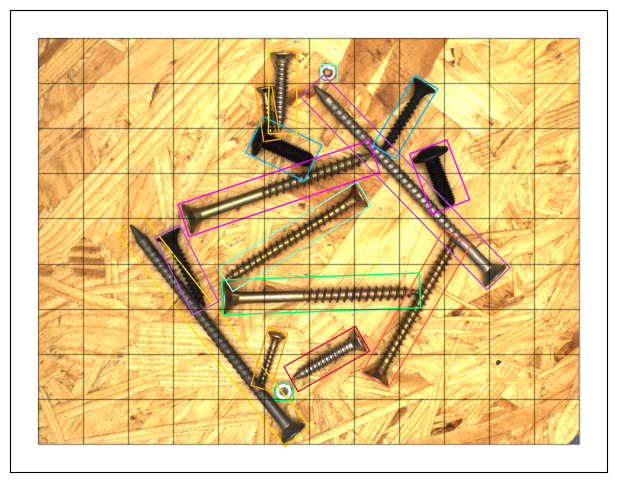

In [410]:
fig, ax = setup_labels_plot()
ax = ax[0]
# --------------------
# Object Setup
# --------------------
cell = 46
bb_list = [0, 6]
itm_list = [1, 4]
x = 0
y = 388
# for i, a in zip(bb_list, itm_list):
for i in range(18):
    if label_corners[0, i, 0, 0] == 0:
        continue
    n_color = next(color)
    ax.add_patch(Polygon(label_corners[0, i], fill=False, edgecolor=n_color))
    ax.imshow(imgs[0] / 255)
    x += 150
plt.show()